# Exploring the Data

## Table of Contents
* [Loading the Data](#loading_data)
* [Attributes characteristics](#info)
    - [Building metadata attributes](#building_features)
    - [Weather parameters](#weather_param)
    - [Target attribute](#target)
* [Missing values](#missing)
* [Anomalies](#anomalies)
* [Correlations](#corr)
* [Transformations identification](#transformations)

In [10]:
# Libraries

%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import pandas as pd
import numpy as np
import datetime as dt
import gc
import missingno as msno
import pandas_profiling
import statsmodels as sm
from statsmodels.tsa.seasonal import seasonal_decompose

from src.functions import data_import as dimp
from src.functions import data_exploration as dexp

#visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly as pty

import plotly.graph_objs as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import cufflinks as cf
cf.set_config_file(offline=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Loading the data
<a id="getting_data"></a>

In [3]:
# site 4 dataset
file = '../../data/interim/by_site/site_4.csv'
df_s4 = dimp.import_data(file)

Memory usage of dataframe is 85.46 MB
Memory usage after optimization is: 21.03 MB
Decreased by 75.4%


## Attributes characteristics
<a id="info"></a>

In [27]:
# Dataset dimension
df_s4.shape

(746746, 15)

In [28]:
# Type of attributes
df_s4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 746746 entries, 0 to 746745
Data columns (total 15 columns):
building_id           746746 non-null int16
meter                 746746 non-null int8
year_built            736951 non-null float16
primary_use           746746 non-null category
floor_count           746746 non-null int8
square_feet           746746 non-null int32
timestamp             746746 non-null category
air_temperature       746664 non-null float16
cloud_coverage        387660 non-null float16
dew_temperature       746492 non-null float16
precip_depth_1_hr     634227 non-null float16
sea_level_pressure    740421 non-null float16
wind_direction        737751 non-null float16
wind_speed            746664 non-null float16
meter_reading         746746 non-null float16
dtypes: category(2), float16(9), int16(1), int32(1), int8(2)
memory usage: 21.0 MB


In [29]:
# Dataset sample
df_s4.head()

building_id  meter  year_built primary_use  floor_count  square_feet  \
0          565      0      1954.0   Education            2        15326   
1          565      0      1954.0   Education            2        15326   
2          565      0      1954.0   Education            2        15326   
3          565      0      1954.0   Education            2        15326   
4          565      0      1954.0   Education            2        15326   

             timestamp  air_temperature  cloud_coverage  dew_temperature  \
0  2016-01-01 00:00:00              NaN             NaN              NaN   
1  2016-01-01 01:00:00         9.398438             0.0        -2.199219   
2  2016-01-01 02:00:00         8.296875             0.0        -2.800781   
3  2016-01-01 03:00:00         7.800781             0.0        -2.800781   
4  2016-01-01 04:00:00         5.000000             0.0        -0.600098   

   precip_depth_1_hr  sea_level_pressure  wind_direction  wind_speed  \
0                NaN                 NaN             NaN         NaN   
1                0.0              1021.5           360.0    3.099609   
2                0.0              1021.5             0.0    0.000000   
3                0.0              1021.5            90.0    1.500000   
4                0.0              1022.0             0.0    0.000000   

   meter_reading  
0           7.25  
1           8.50  
2           7.25  
3           7.50  
4           8.00

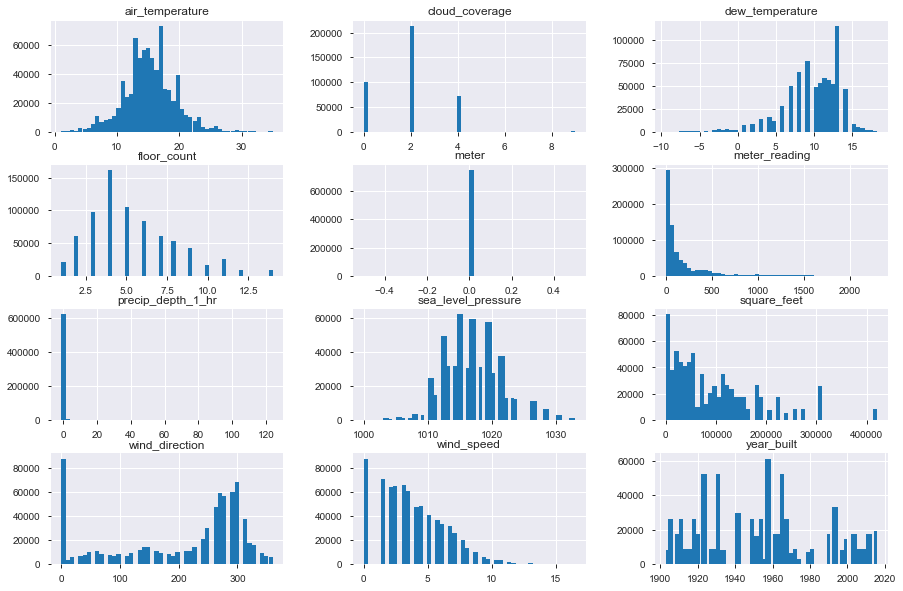

In [30]:
# Type of distribution for numerical attributes
%matplotlib inline
df_s4.drop(['timestamp','building_id'], axis=1).hist(bins=50, figsize=(15,10))
plt.show()

In [31]:
# number of buildings in site_4
nb = len(df_s4['building_id'].unique())
print(f'There are {nb} buildings in site 4.')

There are 91 buildings in site 4.


### Building metadata attributes
<a id="building_features"></a>

In [32]:
building_metada = ['year_built','primary_use','floor_count','square_feet','meter']
df_s4[building_metada].describe()

year_built    floor_count    square_feet     meter
count    736951.0  746746.000000  746746.000000  746746.0
mean          NaN       5.394139   95214.353837       0.0
std           NaN       2.671154   85234.184956       0.0
min        1903.0       1.000000     387.000000       0.0
25%        1924.0       4.000000   29063.000000       0.0
50%        1954.0       5.000000   68701.000000       0.0
75%        1970.0       7.000000  137806.000000       0.0
max        2016.0      14.000000  420885.000000       0.0

In [33]:
# proportion (in %) of `primary_use` categories
round((df_s4.groupby('primary_use')['building_id'].count() / df_s4.shape[0])*100, 2)

primary_use
Education                        74.64
Entertainment/public assembly     8.33
Lodging/residential               3.97
Parking                           2.76
Public services                   6.78
Technology/science                2.35
Utility                           1.17
Name: building_id, dtype: float64

Some insights from exploring building metadata:
* There's only one type of meter: `{0: electricity}`.
* There're many relative old buildings (54% are over 60 years old). Only 25% are less than 50 years old.
* Many buildings have more than one floor (50% have 5 or more floors). 
* There buildings from 35 m$^2$ (very small) to more than 40k m$^2$ (very big).
* There are 7 different types of primary use for the buildings. Near 75% are education buildings (schools, universities, ...).

### Weather parameters
<a id="weather_param"></a>

Let's visualize the weather variables vs. time for a sample building (remember weather data come from a meteorological station as close as possible to the site, so all buildings share the same weather data source).

In [4]:
# Visualizations for building_id 565
df_s4_565 = df_s4[df_s4.building_id == 565]
df_s4_565['timestamp'] = pd.to_datetime(df_s4_565['timestamp']) 

df_s4_565.set_index('timestamp')[
    [
        'air_temperature',
        'cloud_coverage',
        'dew_temperature',
        'sea_level_pressure',
        'precip_depth_1_hr',
        'wind_direction',
        'wind_speed',
        'meter_reading'
    ]
].iplot(kind='scatter', filename='cufflinks/cf-simple-line')


It's weird that the maximum daily temperature occurs at night. Morover, both temperature and electricity consumption peaks shall occur at the same time after midday for an Educational building, the time difference between these peaks we see in the plot above is about 7/8 hours. We can conclude **timestamp in weather data in site 4 is GMT and meter reading timestamp is in GMT-8 (local time). We need to fix this**.

### Target attribute
<a id="target"></a>

The target attribute is `meter_reading`, the value of the electricity consumption every hour, in kWh. Let's check its behaviour over time by looking at its decomposition to see the seasonality, trend, etc.

#### Educational Building

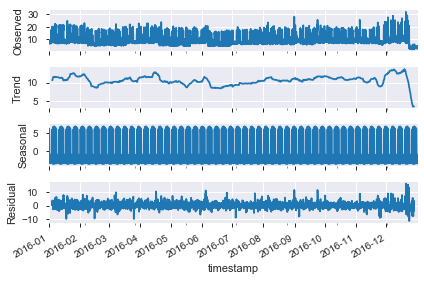

In [25]:
serie = df_s4_565.set_index('timestamp')['meter_reading']
result = seasonal_decompose(serie, model='additive', freq=168)
result.plot()
plt.show()

Some insights:
* Generaly, there is a dayly seasonality, with a peak in consumption at midday, and a minimum at night.
* There're periods where this seasonality doesn't exist, and the consumption is low and almost constant, for example, from 2016/12/23 to 2019/12/31. It seems to correspond to Christmas holidays, where the Educational buildings have a low or null activity.
* At several weekends (saturday and sunday), we can see also low and constant consumption.
* 4th July has low and constant consumption, with is likely to be due to a holiday (USA Indepence day?!).

## Missing values
<a id="missing"></a>

In [26]:
# Percentage of missing values in each variable, grouped by building_id
dexp.get_missing_percentage(
    df_s4.set_index(['building_id','timestamp'])
)

meter                  0.00
year_built             1.31
primary_use            0.00
floor_count            0.00
square_feet            0.00
air_temperature        0.01
cloud_coverage        48.09
dew_temperature        0.03
precip_depth_1_hr     15.07
sea_level_pressure     0.85
wind_direction         1.20
wind_speed             0.01
meter_reading          0.00
dtype: float64

## Transformations identification
<a id="transformations"></a>

* Convert `timestamp`to date time as it is imported as categorical type.
* Align time zones between meter reading timestamp and weather parameters timestamp. Concretely, we need to convert weather timestamps to local time.
* Convert `year_built` to integer, now is a float.
* Delete attribute `meter` as there's only one type of meter, `{0: electricity}`. 
* Input `air_temperature` and `dew_temperature` missing values by interpolation.